In [4]:
from collections import defaultdict

In [5]:
from struct import unpack_from, unpack

In [6]:
import numpy as np
import os
import re

In [7]:
from datetime import datetime as dt

In [8]:
from matplotlib.dates import date2num

In [9]:
from echosounder_model import BaseEnum

In [12]:
BLOCK_SIZE = 1024*4             # Block size read in from binary file to search for token

In [10]:
LENGTH_SIZE = 4
DATAGRAM_HEADER_SIZE = 12
CONFIG_HEADER_SIZE = 516
CONFIG_TRANSDUCER_SIZE = 320

# set global regex expressions to find all sample, annotation and NMEA sentences
SAMPLE_REGEX = r'RAW\d{1}'
SAMPLE_MATCHER = re.compile(SAMPLE_REGEX, re.DOTALL)

In [11]:
# Reference time "seconds since 1900-01-01 00:00:00"
REF_TIME = date2num(dt(1900, 1, 1, 0, 0, 0))

In [13]:
# ---------- NEED A GENERIC FILENAME PARSER -------------
# Common EK60 *.raw filename format
# EK60_RAW_NAME_REGEX = r'(?P<Refdes>\S*)_*OOI-D(?P<Date>\d{8})-T(?P<Time>\d{6})\.raw'
# EK60_RAW_NAME_MATCHER = re.compile(EK60_RAW_NAME_REGEX)

# Regex to extract the timestamp from the *.raw filename (path/to/OOI-DYYYYmmdd-THHMMSS.raw)
FILE_NAME_REGEX = r'(?P<Refdes>\S*)_*OOI-D(?P<Date>\d{8})-T(?P<Time>\d{6})\.raw'
FILE_NAME_MATCHER = re.compile(FILE_NAME_REGEX)

WINDOWS_EPOCH = dt(1601, 1, 1)
NTP_EPOCH = dt(1900, 1, 1)
NTP_WINDOWS_DELTA = (NTP_EPOCH - WINDOWS_EPOCH).total_seconds()

## Function definitions

The following functions are from `zplsc_b.py` and `zplsc_echogram.py` and are used when parsing *.raw files.

In [38]:
def read_config_header(chunk):
    """
    Reads the EK60 raw data file configuration header information
    from the byte string passed in as a chunk
    @param chunk data chunk to read the config header from
    @return: configuration header
    """
    # setup unpack structure and field names
    field_names = ('survey_name', 'transect_name', 'sounder_name',
                   'version', 'transducer_count')
    fmt = '<128s128s128s30s98sl'

    # read in the values from the byte string chunk
    values = list(unpack(fmt, chunk))
    values.pop(4)  # drop the spare field

    # strip the trailing zero byte padding from the strings
    # for i in [0, 1, 2, 3]:
    for i in range(4):
        values[i] = values[i].strip(b'\x00')

    # create the configuration header dictionary
    config_header = dict(zip(field_names, values))
    return config_header

In [43]:
def read_config_transducer(chunk):
    """
    Reads the EK60 raw data file configuration transducer information
    from the byte string passed in as a chunk
    @param chunk data chunk to read the configuration transducer information from
    @return: configuration transducer information
    """

    # setup unpack structure and field names
    field_names = ('channel_id', 'beam_type', 'frequency', 'gain',
                   'equiv_beam_angle', 'beam_width_alongship', 'beam_width_athwartship',
                   'angle_sensitivity_alongship', 'angle_sensitivity_athwartship',
                   'angle_offset_alongship', 'angle_offset_athwart', 'pos_x', 'pos_y',
                   'pos_z', 'dir_x', 'dir_y', 'dir_z', 'pulse_length_table', 'gain_table',
                   'sa_correction_table', 'gpt_software_version')
    fmt = '<128sl15f5f8s5f8s5f8s16s28s'

    # read in the values from the byte string chunk
    values = list(unpack(fmt, chunk))

    # convert some of the values to arrays
    pulse_length_table = np.array(values[17:22])
    gain_table = np.array(values[23:28])
    sa_correction_table = np.array(values[29:34])

    # strip the trailing zero byte padding from the strings
    for i in [0, 35]:
        values[i] = values[i].strip(b'\x00')

    # put it back together, dropping the spare strings
    config_transducer = dict(zip(field_names[0:17], values[0:17]))
    config_transducer[field_names[17]] = pulse_length_table
    config_transducer[field_names[18]] = gain_table
    config_transducer[field_names[19]] = sa_correction_table
    config_transducer[field_names[20]] = values[35]
    return config_transducer

In [51]:
def read_header(filehandle):
    # Read binary file a block at a time
    raw = filehandle.read(BLOCK_SIZE)

    # Read the configuration datagram, output at the beginning of the file
    length1, = unpack_from('<l', raw)
    byte_cnt = LENGTH_SIZE

    # Configuration datagram header
    byte_cnt += DATAGRAM_HEADER_SIZE

    # Configuration: header
    config_header = read_config_header(raw[byte_cnt:byte_cnt+CONFIG_HEADER_SIZE])
    byte_cnt += CONFIG_HEADER_SIZE
    config_transducer = []
    for num_transducer in range(config_header['transducer_count']):
        config_transducer.append(read_config_transducer(raw[byte_cnt:byte_cnt+CONFIG_TRANSDUCER_SIZE]))
        byte_cnt += CONFIG_TRANSDUCER_SIZE
    #byte_cnt += CONFIG_TRANSDUCER_SIZE * config_header['transducer_count']

    # Compare length1 (from beginning of datagram) to length2 (from the end of datagram) to
    # the actual number of bytes read. A mismatch can indicate an invalid, corrupt, misaligned,
    # or missing configuration datagram or a reverse byte order binary data file.
    # A bad/missing configuration datagram header is a significant error.
    length2, = unpack_from('<l', raw, byte_cnt)
    if not (length1 == length2 == byte_cnt-LENGTH_SIZE):
        print('Possible file corruption or format incompatibility.')
#         raise InstrumentDataException(
#             "Length of configuration datagram and number of bytes read do not match: length1: %s"
#             ", length2: %s, byte_cnt: %s. Possible file corruption or format incompatibility." %
#             (length1, length2, byte_cnt+LENGTH_SIZE))
    byte_cnt += LENGTH_SIZE
    filehandle.seek(byte_cnt)
    return config_header, config_transducer

In [16]:
class ZplscBParticleKey(BaseEnum):
    """
    Class that defines fields that need to be extracted from the data
    """
    FILE_TIME = "zplsc_timestamp"               # raw file timestamp
    ECHOGRAM_PATH = "filepath"                  # output echogram plot .png/s path and filename
    CHANNEL = "zplsc_channel"
    TRANSDUCER_DEPTH = "zplsc_transducer_depth" # five digit floating point number (%.5f, in meters)
    FREQUENCY = "zplsc_frequency"               # six digit fixed point integer (in Hz)
    TRANSMIT_POWER = "zplsc_transmit_power"     # three digit fixed point integer (in Watts)
    PULSE_LENGTH = "zplsc_pulse_length"         # six digit floating point number (%.6f, in seconds)
    BANDWIDTH = "zplsc_bandwidth"               # five digit floating point number (%.5f in Hz)
    SAMPLE_INTERVAL = "zplsc_sample_interval"   # six digit floating point number (%.6f, in seconds)
    SOUND_VELOCITY = "zplsc_sound_velocity"     # five digit floating point number (%.5f, in m/s)
    ABSORPTION_COEF = "zplsc_absorption_coeff"  # four digit floating point number (%.4f, dB/m)
    TEMPERATURE = "zplsc_temperature"           # three digit floating point number (%.3f, in degC)


In [17]:
# The following is used for _build_parsed_values() and defined as below:
# (parameter name, encoding function)
METADATA_ENCODING_RULES = [
    (ZplscBParticleKey.FILE_TIME, str),
    (ZplscBParticleKey.ECHOGRAM_PATH, str),
    (ZplscBParticleKey.CHANNEL, lambda x: [int(y) for y in x]),
    (ZplscBParticleKey.TRANSDUCER_DEPTH, lambda x: [float(y) for y in x]),
    (ZplscBParticleKey.FREQUENCY, lambda x: [float(y) for y in x]),
    (ZplscBParticleKey.TRANSMIT_POWER, lambda x: [float(y) for y in x]),
    (ZplscBParticleKey.PULSE_LENGTH, lambda x: [float(y) for y in x]),
    (ZplscBParticleKey.BANDWIDTH, lambda x: [float(y) for y in x]),
    (ZplscBParticleKey.SAMPLE_INTERVAL, lambda x: [float(y) for y in x]),
    (ZplscBParticleKey.SOUND_VELOCITY, lambda x: [float(y) for y in x]),
    (ZplscBParticleKey.ABSORPTION_COEF, lambda x: [float(y) for y in x]),
    (ZplscBParticleKey.TEMPERATURE, lambda x: [float(y) for y in x])
]

In [18]:
# Numpy data type object for unpacking the Sample datagram including the header from binary *.raw
sample_dtype = np.dtype([('length1', 'i4'),  # 4 byte int (long)
                            # DatagramHeader
                            ('datagram_type', 'a4'),  # 4 byte string
                            ('low_date_time', 'u4'),  # 4 byte int (long)
                            ('high_date_time', 'u4'),  # 4 byte int (long)
                            # SampleDatagram
                            ('channel_number', 'i2'),  # 2 byte int (short)
                            ('mode', 'i2'),  # 2 byte int (short)
                            ('transducer_depth', 'f4'),  # 4 byte float
                            ('frequency', 'f4'),  # 4 byte float
                            ('transmit_power', 'f4'),  # 4 byte float
                            ('pulse_length', 'f4'),  # 4 byte float
                            ('bandwidth', 'f4'),  # 4 byte float
                            ('sample_interval', 'f4'),  # 4 byte float
                            ('sound_velocity', 'f4'),  # 4 byte float
                            ('absorption_coefficient', 'f4'),  # 4 byte float
                            ('heave', 'f4'),  # 4 byte float
                            ('roll', 'f4'),  # 4 byte float
                            ('pitch', 'f4'),  # 4 byte float
                            ('temperature', 'f4'),  # 4 byte float
                            ('trawl_upper_depth_valid', 'i2'),  # 2 byte int (short)
                            ('trawl_opening_valid', 'i2'),  # 2 byte int (short)
                            ('trawl_upper_depth', 'f4'),  # 4 byte float
                            ('trawl_opening', 'f4'),  # 4 byte float
                            ('offset', 'i4'),  # 4 byte int (long)
                            ('count', 'i4')])                     # 4 byte int (long)
sample_dtype = sample_dtype.newbyteorder('<')

power_dtype = np.dtype([('power_data', '<i2')])     # 2 byte int (short)

angle_dtype = np.dtype([('athwart', '<i1'), ('along', '<i1')])     # 1 byte ints

In [19]:
def windows_to_ntp(windows_time):
    """
    Convert a windows file timestamp into Network Time Protocol
    :param windows_time:  100ns since Windows time epoch
    :return:
    """
    return windows_time / 1e7 - NTP_WINDOWS_DELTA


def build_windows_time(high_word, low_word):
    """
    Generate Windows time value from high and low date times.

    :param high_word:  high word portion of the Windows datetime
    :param low_word:   low word portion of the Windows datetime
    :return:  time in 100ns since 1601/01/01 00:00:00 UTC
    """
    return (high_word << 32) + low_word

In [20]:
def extract_file_time(filepath):
    match = FILE_NAME_MATCHER.match(filepath)
    if match:
        return match.group('Date') + match.group('Time')
    else:
        # Files retrieved from the instrument should always match the timestamp naming convention
        error_message = \
            "Unable to extract file time from input file name: %s. Expected format *-DYYYYmmdd-THHMMSS.raw" \
            % filepath
        log.error(error_message)
        raise InstrumentDataException(error_message)

In [395]:
def process_sample(input_file, transducer_count):
    # log.trace('Processing one sample from input_file: %r', input_file)
    print('Processing one sample from input_file: %s' % input_file_path)

    # Read and unpack the Sample Datagram into numpy array
    sample_data = np.fromfile(input_file, dtype=sample_dtype, count=1)
    channel = sample_data['channel_number'][0]

    # Check for a valid channel number that is within the number of transducers config
    # to prevent incorrectly indexing into the dictionaries.
    # An out of bounds channel number can indicate invalid, corrupt,
    # or misaligned datagram or a reverse byte order binary data file.
    # Log warning and continue to try and process the rest of the file.
    if channel < 0 or channel > transducer_count:
        print('Invalid channel: %s for transducer count: %s. \n\
        Possible file corruption or format incompatibility.' % (channel, transducer_count))
        # log.warn("Invalid channel: %s for transducer count: %s."
        #          "Possible file corruption or format incompatibility.", channel, transducer_count)
        # raise InvalidTransducer

    # Convert high and low bytes to internal time
    windows_time = build_windows_time(sample_data['high_date_time'][0], sample_data['low_date_time'][0])
    ntp_time = windows_to_ntp(windows_time)

    count = sample_data['count'][0]

    # Extract array of power data
    power_data = np.fromfile(input_file, dtype=power_dtype, count=count).astype('f8')

    # Read the athwartship and alongship angle measurements
    if sample_data['mode'][0] > 1:
        angle_data = np.fromfile(input_file, dtype=angle_dtype, count=count)
    else:
        angle_data = []

    # Read and compare length1 (from beginning of datagram) to length2
    # (from the end of datagram). A mismatch can indicate an invalid, corrupt,
    # or misaligned datagram or a reverse byte order binary data file.
    # Log warning and continue to try and process the rest of the file.
    len_dtype = np.dtype([('length2', '<i4')])  # 4 byte int (long)
    length2_data = np.fromfile(input_file, dtype=len_dtype, count=1)
    if not (sample_data['length1'][0] == length2_data['length2'][0]):
        print('Mismatching beginning and end length values in sample datagram: \n\
        length1: %d, length2: %d.\n\
        Possible file corruption or format incompatibility.' % (sample_data['length1'][0], length2_data['length2'][0]))
        # log.warn("Mismatching beginning and end length values in sample datagram: length1"
        #          ": %s, length2: %s. Possible file corruption or format incompatibility.",
        #          sample_data['length1'][0], length2_data['length2'][0])

    return channel, ntp_time, sample_data, power_data, angle_data

In [384]:
def append_metadata(metadata, file_time, channel, sample_data):
    metadata[ZplscBParticleKey.FILE_TIME] = file_time
    #metadata[ZplscBParticleKey.ECHOGRAM_PATH]= file_path
    metadata[ZplscBParticleKey.CHANNEL].append(channel)
    metadata[ZplscBParticleKey.TRANSDUCER_DEPTH].append(sample_data['transducer_depth'][0])
    metadata[ZplscBParticleKey.FREQUENCY].append(sample_data['frequency'][0])
    metadata[ZplscBParticleKey.TRANSMIT_POWER].append(sample_data['transmit_power'][0])
    metadata[ZplscBParticleKey.PULSE_LENGTH].append(sample_data['pulse_length'][0])
    metadata[ZplscBParticleKey.BANDWIDTH].append(sample_data['bandwidth'][0])
    metadata[ZplscBParticleKey.SAMPLE_INTERVAL].append(sample_data['sample_interval'][0])
    metadata[ZplscBParticleKey.SOUND_VELOCITY].append(sample_data['sound_velocity'][0])
    metadata[ZplscBParticleKey.ABSORPTION_COEF].append(sample_data['absorption_coefficient'][0])
    metadata[ZplscBParticleKey.TEMPERATURE].append(sample_data['temperature'][0])
    return metadata

In [402]:
def parse_echogram_file(input_file_path):   #, output_file_path=None):
    """
    Parse the *.raw file.
    @param input_file_path absolute path/name to file to be parsed
    # @param output_file_path optional path to directory to write output
    If omitted outputs are written to path of input file
    """
    print('%s  unpacking file: %s' % (dt.now().strftime('%H:%M:%S'), input_file_path))
    # image_path = generate_image_file_path(input_file_path, output_file_path)

    file_time = extract_file_time(input_file_path)  # time at file generation

    with open(input_file_path, 'rb') as input_file:  # read ('r') input file using binary mode ('b')

        config_header, config_transducer = read_header(input_file)
        transducer_count = config_header['transducer_count']

        transducer_keys = range(1, transducer_count+1)
        frequencies = dict.fromkeys(transducer_keys)       # transducer frequency
        bin_size = None                                    # transducer depth measurement

        position = input_file.tell()
        particle_data = None

        last_time = None
        sample_data_temp_dict = {}
        power_data_temp_dict = {}

        power_data_dict = {}
        data_times = []
        temperature = []   # WJ: Used to check temperature reading in .RAW file --> all identical for OOI data

        # Read binary file a block at a time
        raw = input_file.read(BLOCK_SIZE)

        while len(raw) > 4:
            # We only care for the Sample datagrams, skip over all the other datagrams
            match = SAMPLE_MATCHER.search(raw)

            if match:
                # Offset by size of length value
                match_start = match.start() - LENGTH_SIZE

                # Seek to the position of the length data before the token to read into numpy array
                input_file.seek(position + match_start)

                # try:
                next_channel, next_time, next_sample, next_power, next_angle = process_sample(input_file, transducer_count)

                if next_time != last_time:  # WJ: next_time=last_time when it's the same ping but different channel
                    # Clear out our temporary dictionaries and set the last time to this time
                    sample_data_temp_dict = {}
                    power_data_temp_dict = {}
                    angle_data_temp_dict = {}
                    last_time = next_time

                # Store this data
                sample_data_temp_dict[next_channel] = next_sample
                power_data_temp_dict[next_channel] = next_power
                angle_data_temp_dict[next_channel] = next_angle

                # Check if we have enough records to produce a new row of data
                # WJ: if yes this means that data from all transducer channels have been read for a particular ping
                # WJ: a new row of data means all data from one ping
                # WJ: if only 2 channels of data were received, they are not stored in the final power_data_dict
                if len(sample_data_temp_dict) == len(power_data_temp_dict) == len(angle_data_temp_dict) == transducer_count:
                    # if this is our first set of data, create our metadata particle and store
                    # the frequency / bin_size data
                    if not power_data_dict:
                        # relpath = generate_relative_file_path(image_path)
                        first_ping_metadata = defaultdict(list)
                        for channel, sample_data in sample_data_temp_dict.items():
                            append_metadata(first_ping_metadata, file_time, channel, sample_data)

                            frequency = sample_data['frequency'][0]
                            frequencies[channel] = frequency

                            if bin_size is None:
                                bin_size = sample_data['sound_velocity'] * sample_data['sample_interval'] / 2

                        #particle_data = first_ping_metadata, next_time  # WJ: probably don't need to append next_time here
                        power_data_dict = {channel: [] for channel in power_data_temp_dict}

                    # Save the time and power data for plotting
                    data_times.append(next_time)
                    for channel in power_data_temp_dict:
                        power_data_dict[channel].append(power_data_temp_dict[channel])

                    temperature.append(next_sample['temperature'])  # WJ: check temperature values from .RAW file: all identical for OOI data

                # except InvalidTransducer:
                #   pass

            else:
                input_file.seek(position + BLOCK_SIZE - 4)

            # Need current position in file to increment for next regex search offset
            position = input_file.tell()
            # Read the next block for regex search
            raw = input_file.read(BLOCK_SIZE)

        # convert ntp time, i.e. seconds since 1900-01-01 00:00:00 to matplotlib time
        data_times = np.array(data_times)
        data_times = (data_times / (60 * 60 * 24)) + REF_TIME

        # Convert to numpy array and decompress power data to dB
        # And then transpose power data
        for channel in power_data_dict:
            power_data_dict[channel] = np.array(power_data_dict[channel]) * 10. * np.log10(2) / 256.
            power_data_dict[channel] = power_data_dict[channel].transpose()

        # WJ: Rename keys in power data to according to transducer frequency
        for channel in power_data_dict:
            power_data_dict[frequencies[channel]] = power_data_dict.pop(channel)

        return first_ping_metadata, data_times, power_data_dict, frequencies, bin_size, config_header, config_transducer

## Figuring out `parse_echogram_file`

In [54]:
input_file_path = 'OOI-D20150901-T000000.raw'

In [55]:
print('%s  unpacking file: %s' % (dt.now().strftime('%H:%M:%S'), input_file_path))

13:17:48  unpacking file: OOI-D20150901-T000000.raw


In [56]:
file_time = extract_file_time(input_file_path)  # time at file generation
file_time

'20150901000000'

In [57]:
input_file = open(input_file_path, 'rb')

In [58]:
input_file

<_io.BufferedReader name='OOI-D20150901-T000000.raw'>

In [59]:
        config_header, config_transducer = read_header(input_file)
        transducer_count = config_header['transducer_count']

In [60]:
transducer_count

3

In [61]:
config_header

{'sounder_name': b'ER60',
 'survey_name': b'OOI',
 'transducer_count': 3,
 'transect_name': b'',
 'version': b'2.4.3'}

In [62]:
config_transducer

[{'angle_offset_alongship': 0.0,
  'angle_offset_athwart': 0.0,
  'angle_sensitivity_alongship': 23.0,
  'angle_sensitivity_athwartship': 23.0,
  'beam_type': 1,
  'beam_width_alongship': 7.0,
  'beam_width_athwartship': 7.0,
  'channel_id': b'GPT 120 kHz 00907208a0b1 3-1 ES120-7CD',
  'dir_x': 0.0,
  'dir_y': 0.0,
  'dir_z': 0.0,
  'equiv_beam_angle': -20.700000762939453,
  'frequency': 120000.0,
  'gain': 25.0,
  'gain_table': array([23.5       , 24.79999924, 25.        , 25.        , 25.        ]),
  'gpt_software_version': b'070413',
  'pos_x': 0.0,
  'pos_y': 0.0,
  'pos_z': 0.0,
  'pulse_length_table': array([6.39999998e-05, 1.28000000e-04, 2.55999999e-04, 5.11999999e-04,
         1.02400000e-03]),
  'sa_correction_table': array([0., 0., 0., 0., 0.])},
 {'angle_offset_alongship': 0.0,
  'angle_offset_athwart': 0.0,
  'angle_sensitivity_alongship': 21.899999618530273,
  'angle_sensitivity_athwartship': 21.899999618530273,
  'beam_type': 0,
  'beam_width_alongship': 7.0999999046325

In [64]:
        transducer_keys = range(1, transducer_count+1)
        frequencies = dict.fromkeys(transducer_keys)       # transducer frequency
        bin_size = None                                    # transducer depth measurement

In [66]:
frequencies

{1: None, 2: None, 3: None}

In [67]:
        position = input_file.tell()
        particle_data = None

        last_time = None
        sample_data_temp_dict = {}
        power_data_temp_dict = {}

        power_data_dict = {}
        data_times = []
        temperature = []   # WJ: Used to check temperature reading in .RAW file --> all identical for OOI data

In [69]:
position  # position after reading headers

1496

In [70]:
raw = input_file.read(BLOCK_SIZE)

In [72]:
len(raw)

4096

In [74]:
raw

b'$\x00\x00\x00NME0\xa8P\'%I\xe4\xd0\x01$SDVLW,0.000,N,0.000,N\x00\x00$\x00\x00\x00\xac\x10\x00\x00RAW0\xa8P\'%I\xe4\xd0\x01\x01\x00\x03\x00\x00\x00\x00\x00\x00`\xeaG\x00\x00zC\xbd7\x86:D&=E\xbd7\x869q\xbc\xbaD\x03[\x19=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 A\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x16\x04\x00\x00\xb9\xfe\x8b\x00\x89\x00\x86\x00\xa9\xfe)\xe9\xd8\xe5I\xde\xc2\xdf7\xe0\xa6\xde?\xdb\x8e\xdc\x1e\xdb\x83\xda3\xda\xb9\xd9\x92\xd8u\xd9\x9d\xd9K\xd7k\xd9\xa0\xd9\x03\xda\xa0\xdc\xd7\xdc)\xdb\xf9\xd8p\xd6\x18\xd6\xc9\xd6\xa4\xd4\xe3\xd2*\xd6N\xd8\xd9\xd7\x0b\xd7\xb6\xd3\xe4\xd6*\xd7\xd6\xd47\xd7z\xd6h\xd6?\xd9\x8c\xd9\x89\xd4\x92\xd8I\xdaE\xda\xfc\xd5\x95\xcd\xe0\xd5?\xd5\xa8\xd5\xe3\xd5\xc1\xd5x\xd7\xee\xd6\x8f\xd5\xb9\xd4\x81\xd5\xe3\xd6\xa1\xd7T\xd7\x94\xd7\n\xd5\x0b\xd6\xec\xd5\xdb\xd6\xc0\xda\x19\xdb)\xdbd\xda\xa9\xd2\xa7\xda\xab\xdb\x9e\xdbk\xdb\x04\xd6\xe7\xd4h\xd59\xd3E\xd1\x81\xd2W\xd3\x92\xd8C\xdaZ\xda;\xda\xa9\xd7\x9a\xd7\xf3

In [114]:
# set global regex expressions to find all sample, annotation and NMEA sentences
SAMPLE_REGEX = b'RAW\d{1}'
SAMPLE_MATCHER = re.compile(SAMPLE_REGEX, re.DOTALL)

In [115]:
match = SAMPLE_MATCHER.search(raw)

In [116]:
match

<_sre.SRE_Match object; span=(48, 52), match=b'RAW0'>

In [119]:
# Offset by size of length value
match_start = match.start() - LENGTH_SIZE

In [121]:
# Seek to the position of the length data before the token to read into numpy array
input_file.seek(position + match_start)

1540

### figuring out `process_sample`

In [126]:
print('Processing one sample from input_file: %s' % input_file_path)

Processing one sample from input_file: OOI-D20150901-T000000.raw


In [128]:
sample_data = np.fromfile(input_file, dtype=sample_dtype, count=1)

In [130]:
sample_data

array([(4268, b'RAW0', 623333544, 30467145, 1, 3, 0., 120000., 250., 0.001024, 3026.3916, 0.000256, 1493.8888, 0.03744031, 0., 0., 0., 10., 0, 0, 0., 0., 0, 1046)],
      dtype=[('length1', '<i4'), ('datagram_type', 'S4'), ('low_date_time', '<u4'), ('high_date_time', '<u4'), ('channel_number', '<i2'), ('mode', '<i2'), ('transducer_depth', '<f4'), ('frequency', '<f4'), ('transmit_power', '<f4'), ('pulse_length', '<f4'), ('bandwidth', '<f4'), ('sample_interval', '<f4'), ('sound_velocity', '<f4'), ('absorption_coefficient', '<f4'), ('heave', '<f4'), ('roll', '<f4'), ('pitch', '<f4'), ('temperature', '<f4'), ('trawl_upper_depth_valid', '<i2'), ('trawl_opening_valid', '<i2'), ('trawl_upper_depth', '<f4'), ('trawl_opening', '<f4'), ('offset', '<i4'), ('count', '<i4')])

In [131]:
sample_dtype

dtype([('length1', '<i4'), ('datagram_type', 'S4'), ('low_date_time', '<u4'), ('high_date_time', '<u4'), ('channel_number', '<i2'), ('mode', '<i2'), ('transducer_depth', '<f4'), ('frequency', '<f4'), ('transmit_power', '<f4'), ('pulse_length', '<f4'), ('bandwidth', '<f4'), ('sample_interval', '<f4'), ('sound_velocity', '<f4'), ('absorption_coefficient', '<f4'), ('heave', '<f4'), ('roll', '<f4'), ('pitch', '<f4'), ('temperature', '<f4'), ('trawl_upper_depth_valid', '<i2'), ('trawl_opening_valid', '<i2'), ('trawl_upper_depth', '<f4'), ('trawl_opening', '<f4'), ('offset', '<i4'), ('count', '<i4')])

In [137]:
sample_data['channel_number']

array([1], dtype=int16)

In [138]:
sample_data['channel_number'][0]

1

In [139]:
channel = sample_data['channel_number'][0]

In [141]:
channel < 0 or channel > transducer_count

False

In [142]:
# Convert high and low bytes to internal time
windows_time = build_windows_time(sample_data['high_date_time'][0], sample_data['low_date_time'][0])
ntp_time = windows_to_ntp(windows_time)

In [144]:
windows_time,ntp_time

(130855392000823464, 3650054400.082346)

In [147]:
count = sample_data['count'][0]

In [148]:
count

1046

In [150]:
# Extract array of power data
power_data = np.fromfile(input_file, dtype=power_dtype, count=count).astype('f8')

In [151]:
power_data

array([  -327.,    139.,    137., ..., -11426., -12025., -12158.])

In [157]:
power_data.shape

(1046,)

In [152]:
sample_data['mode'][0]

3

In [154]:
angle_data = np.fromfile(input_file, dtype=angle_dtype, count=count)

In [153]:
angle_dtype

dtype([('athwart', 'i1'), ('along', 'i1')])

In [155]:
angle_data

array([(  1,   0), (  1,   0), (  2,   0), ..., (104, 107), (-26, 121),
       (111, 127)], dtype=[('athwart', 'i1'), ('along', 'i1')])

In [156]:
angle_data.shape

(1046,)

In [171]:
type(sample_data[0])

numpy.void

In [178]:
angle_data[0]['athwart'],angle_data[0]['along']

(1, 0)

To convert `angle_data`, which is a list of arrays, to an ndarray, we can use `numpy.vstack`

In [181]:
angle_data_nparray = np.vstack(angle_data)

In [182]:
angle_data_nparray

array([[(  1,   0)],
       [(  1,   0)],
       [(  2,   0)],
       ...,
       [(104, 107)],
       [(-26, 121)],
       [(111, 127)]], dtype=[('athwart', 'i1'), ('along', 'i1')])

In [185]:
angle_data_nparray['athwart'].T,angle_data_nparray['along'].T

(array([[  1,   1,   2, ..., 104, -26, 111]], dtype=int8),
 array([[  0,   0,   0, ..., 107, 121, 127]], dtype=int8))

In [187]:
# Read and compare length1 (from beginning of datagram) to length2
# (from the end of datagram). A mismatch can indicate an invalid, corrupt,
# or misaligned datagram or a reverse byte order binary data file.
# Log warning and continue to try and process the rest of the file.
len_dtype = np.dtype([('length2', '<i4')])  # 4 byte int (long)
length2_data = np.fromfile(input_file, dtype=len_dtype, count=1)

In [189]:
# if the two numbers below don't equal then the datagram is invalid, corrupt of misaligned
sample_data['length1'][0], length2_data['length2'][0]

(4268, 4268)

Below we read in one more sample (next_*) and it should be from the same ping but different transducer channel.

In [205]:
next_channel, next_time, next_sample, next_power, next_angle = process_sample(input_file, transducer_count)

Processing one sample from input_file: <_io.BufferedReader name='OOI-D20150901-T000000.raw'>


We can verify that these two samples are from the same ping but different channels by checking detail of the data, and see that `channel_number` and `mode` are different but the timing is the same (`next_time` and `ntp_time`). I am guessing `mode` means whether is a split-beam or single-beam transducer). 

In [219]:
next_sample['channel_number'],next_sample['mode'],next_time

(array([3], dtype=int16), array([1], dtype=int16), 3650054400.082346)

In [218]:
sample_data['channel_number'],sample_data['mode'],ntp_time

(array([1], dtype=int16), array([3], dtype=int16), 3650054400.082346)

In [212]:
sample_dtype

dtype([('length1', '<i4'), ('datagram_type', 'S4'), ('low_date_time', '<u4'), ('high_date_time', '<u4'), ('channel_number', '<i2'), ('mode', '<i2'), ('transducer_depth', '<f4'), ('frequency', '<f4'), ('transmit_power', '<f4'), ('pulse_length', '<f4'), ('bandwidth', '<f4'), ('sample_interval', '<f4'), ('sound_velocity', '<f4'), ('absorption_coefficient', '<f4'), ('heave', '<f4'), ('roll', '<f4'), ('pitch', '<f4'), ('temperature', '<f4'), ('trawl_upper_depth_valid', '<i2'), ('trawl_opening_valid', '<i2'), ('trawl_upper_depth', '<f4'), ('trawl_opening', '<f4'), ('offset', '<i4'), ('count', '<i4')])

In [217]:
next_time,last_time

(3650054400.082346, None)

Now we follow the code to store data into two dictionaries.

In [223]:
sample_data_temp_dict = {}
power_data_temp_dict = {}
angle_data_temp_dict = {}

In [224]:
# store the first sample unpacked
sample_data_temp_dict[channel] = sample_data
power_data_temp_dict[channel] = power_data
angle_data_temp_dict[channel] = angle_data

In [225]:
# store the second sample unpacked
sample_data_temp_dict[next_channel] = next_sample
power_data_temp_dict[next_channel] = next_power
angle_data_temp_dict[next_channel] = next_angle

In [226]:
sample_data_temp_dict

{1: array([(4268, b'RAW0', 623333544, 30467145, 1, 3, 0., 120000., 250., 0.001024, 3026.3916, 0.000256, 1493.8888, 0.03744031, 0., 0., 0., 10., 0, 0, 0., 0., 0, 1046)],
       dtype=[('length1', '<i4'), ('datagram_type', 'S4'), ('low_date_time', '<u4'), ('high_date_time', '<u4'), ('channel_number', '<i2'), ('mode', '<i2'), ('transducer_depth', '<f4'), ('frequency', '<f4'), ('transmit_power', '<f4'), ('pulse_length', '<f4'), ('bandwidth', '<f4'), ('sample_interval', '<f4'), ('sound_velocity', '<f4'), ('absorption_coefficient', '<f4'), ('heave', '<f4'), ('roll', '<f4'), ('pitch', '<f4'), ('temperature', '<f4'), ('trawl_upper_depth_valid', '<i2'), ('trawl_opening_valid', '<i2'), ('trawl_upper_depth', '<f4'), ('trawl_opening', '<f4'), ('offset', '<i4'), ('count', '<i4')]),
 3: array([(2176, b'RAW0', 623333544, 30467145, 3, 1, 0., 200000., 150., 0.001024, 3088.4004, 0.000256, 1493.8888, 0.05268759, 0., 0., 0., 10., 0, 0, 0., 0., 0, 1046)],
       dtype=[('length1', '<i4'), ('datagram_type',

In [227]:
frequencies

{1: None, 2: None, 3: None}

Let's read in another sample so that data to see if this sample is from the same ping but a different transducer

In [228]:
next_channel2, next_time2, next_sample2, next_power2, next_angle2 = process_sample(input_file, transducer_count)

Processing one sample from input_file: <_io.BufferedReader name='OOI-D20150901-T000000.raw'>


In [229]:
next_sample2['channel_number'],next_sample2['mode'],next_time2

(array([1], dtype=int16), array([3], dtype=int16), 3650054402.08646)

Based on the pinging time we know that this is not from the same ping as the previous 2 samples we just read. According to the logic of the code, this means that the previous 2 samples will not be stored into the final unpacked data variables `power_data_dict`, `data_times`, `temperature`, etc.

Let's read in another 2 samples to see if we can get data from all 3 transducers at the same ping.

In [230]:
next_channel3, next_time3, next_sample3, next_power3, next_angle3 = \
            process_sample(input_file, transducer_count)
next_channel4, next_time4, next_sample4, next_power4, next_angle4 = \
            process_sample(input_file, transducer_count)

Processing one sample from input_file: <_io.BufferedReader name='OOI-D20150901-T000000.raw'>
Processing one sample from input_file: <_io.BufferedReader name='OOI-D20150901-T000000.raw'>


In [232]:
next_sample3['channel_number'],next_sample3['mode'],next_time3

(array([2], dtype=int16), array([1], dtype=int16), 3650054402.08646)

In [233]:
next_sample4['channel_number'],next_sample4['mode'],next_time4

(array([3], dtype=int16), array([1], dtype=int16), 3650054402.08646)

Yes they are from the same ping! Let's store them properly and go through the rest of the code.

To do this we need to clear out the temp dictionaries first and get the ping time

In [234]:
sample_data_temp_dict = {}
power_data_temp_dict = {}
angle_data_temp_dict = {}
last_time = next_time4

In [235]:
# Store all data
sample_data_temp_dict[next_channel2] = next_sample2
power_data_temp_dict[next_channel2] = next_power2
angle_data_temp_dict[next_channel2] = next_angle2

sample_data_temp_dict[next_channel3] = next_sample3
power_data_temp_dict[next_channel3] = next_power3
angle_data_temp_dict[next_channel3] = next_angle3

sample_data_temp_dict[next_channel4] = next_sample4
power_data_temp_dict[next_channel4] = next_power4
angle_data_temp_dict[next_channel4] = next_angle4

In [236]:
len(sample_data_temp_dict) == len(power_data_temp_dict) == transducer_count

True

In [237]:
not power_data_dict

True

### figuring out `append_metadata` part

In [279]:
first_ping_metadata = defaultdict(list)

In [280]:
first_ping_metadata

defaultdict(list, {})

In [281]:
for channel, sample_data in sample_data_temp_dict.items():
    print(channel)
    print(sample_data)

1
[(4268, b'RAW0', 643374690, 30467145, 1, 3, 0., 120000., 250., 0.001024, 3026.3916, 0.000256, 1493.8888, 0.03744031, 0., 0., 0., 10., 0, 0, 0., 0., 0, 1046)]
2
[(2176, b'RAW0', 643374690, 30467145, 2, 1, 0., 38000., 500., 0.001024, 2425.1497, 0.000256, 1493.8888, 0.00978527, 0., 0., 0., 10., 0, 0, 0., 0., 0, 1046)]
3
[(2176, b'RAW0', 643374690, 30467145, 3, 1, 0., 200000., 150., 0.001024, 3088.4004, 0.000256, 1493.8888, 0.05268759, 0., 0., 0., 10., 0, 0, 0., 0., 0, 1046)]


In [282]:
metadata = first_ping_metadata

In [283]:
# append_metadata(first_ping_metadata, file_time, relpath, channel, sample_data)

In [284]:
channel=1

In [285]:
sample_data = sample_data_temp_dict[1]

In [286]:
metadata[ZplscBParticleKey.FILE_TIME] = file_time
#metadata[ZplscBParticleKey.ECHOGRAM_PATH]= file_path
metadata[ZplscBParticleKey.CHANNEL].append(channel)
metadata[ZplscBParticleKey.TRANSDUCER_DEPTH].append(sample_data['transducer_depth'][0])
metadata[ZplscBParticleKey.FREQUENCY].append(sample_data['frequency'][0])
metadata[ZplscBParticleKey.TRANSMIT_POWER].append(sample_data['transmit_power'][0])
metadata[ZplscBParticleKey.PULSE_LENGTH].append(sample_data['pulse_length'][0])
metadata[ZplscBParticleKey.BANDWIDTH].append(sample_data['bandwidth'][0])
metadata[ZplscBParticleKey.SAMPLE_INTERVAL].append(sample_data['sample_interval'][0])
metadata[ZplscBParticleKey.SOUND_VELOCITY].append(sample_data['sound_velocity'][0])
metadata[ZplscBParticleKey.ABSORPTION_COEF].append(sample_data['absorption_coefficient'][0])
metadata[ZplscBParticleKey.TEMPERATURE].append(sample_data['temperature'][0])

In [287]:
metadata

defaultdict(list,
            {'zplsc_absorption_coeff': [0.03744031],
             'zplsc_bandwidth': [3026.3916],
             'zplsc_channel': [1],
             'zplsc_frequency': [120000.0],
             'zplsc_pulse_length': [0.001024],
             'zplsc_sample_interval': [0.000256],
             'zplsc_sound_velocity': [1493.8888],
             'zplsc_temperature': [10.0],
             'zplsc_timestamp': '20150901000000',
             'zplsc_transducer_depth': [0.0],
             'zplsc_transmit_power': [250.0]})

In [288]:
channel=2
sample_data = sample_data_temp_dict[2]

In [289]:
metadata[ZplscBParticleKey.FILE_TIME] = file_time
#metadata[ZplscBParticleKey.ECHOGRAM_PATH]= file_path
metadata[ZplscBParticleKey.CHANNEL].append(channel)
metadata[ZplscBParticleKey.TRANSDUCER_DEPTH].append(sample_data['transducer_depth'][0])
metadata[ZplscBParticleKey.FREQUENCY].append(sample_data['frequency'][0])
metadata[ZplscBParticleKey.TRANSMIT_POWER].append(sample_data['transmit_power'][0])
metadata[ZplscBParticleKey.PULSE_LENGTH].append(sample_data['pulse_length'][0])
metadata[ZplscBParticleKey.BANDWIDTH].append(sample_data['bandwidth'][0])
metadata[ZplscBParticleKey.SAMPLE_INTERVAL].append(sample_data['sample_interval'][0])
metadata[ZplscBParticleKey.SOUND_VELOCITY].append(sample_data['sound_velocity'][0])
metadata[ZplscBParticleKey.ABSORPTION_COEF].append(sample_data['absorption_coefficient'][0])
metadata[ZplscBParticleKey.TEMPERATURE].append(sample_data['temperature'][0])

In [290]:
metadata

defaultdict(list,
            {'zplsc_absorption_coeff': [0.03744031, 0.009785269],
             'zplsc_bandwidth': [3026.3916, 2425.1497],
             'zplsc_channel': [1, 2],
             'zplsc_frequency': [120000.0, 38000.0],
             'zplsc_pulse_length': [0.001024, 0.001024],
             'zplsc_sample_interval': [0.000256, 0.000256],
             'zplsc_sound_velocity': [1493.8888, 1493.8888],
             'zplsc_temperature': [10.0, 10.0],
             'zplsc_timestamp': '20150901000000',
             'zplsc_transducer_depth': [0.0, 0.0],
             'zplsc_transmit_power': [250.0, 500.0]})

In [291]:
channel=3
sample_data = sample_data_temp_dict[3]

In [292]:
metadata[ZplscBParticleKey.FILE_TIME] = file_time
#metadata[ZplscBParticleKey.ECHOGRAM_PATH]= file_path
metadata[ZplscBParticleKey.CHANNEL].append(channel)
metadata[ZplscBParticleKey.TRANSDUCER_DEPTH].append(sample_data['transducer_depth'][0])
metadata[ZplscBParticleKey.FREQUENCY].append(sample_data['frequency'][0])
metadata[ZplscBParticleKey.TRANSMIT_POWER].append(sample_data['transmit_power'][0])
metadata[ZplscBParticleKey.PULSE_LENGTH].append(sample_data['pulse_length'][0])
metadata[ZplscBParticleKey.BANDWIDTH].append(sample_data['bandwidth'][0])
metadata[ZplscBParticleKey.SAMPLE_INTERVAL].append(sample_data['sample_interval'][0])
metadata[ZplscBParticleKey.SOUND_VELOCITY].append(sample_data['sound_velocity'][0])
metadata[ZplscBParticleKey.ABSORPTION_COEF].append(sample_data['absorption_coefficient'][0])
metadata[ZplscBParticleKey.TEMPERATURE].append(sample_data['temperature'][0])

In [293]:
metadata

defaultdict(list,
            {'zplsc_absorption_coeff': [0.03744031, 0.009785269, 0.05268759],
             'zplsc_bandwidth': [3026.3916, 2425.1497, 3088.4004],
             'zplsc_channel': [1, 2, 3],
             'zplsc_frequency': [120000.0, 38000.0, 200000.0],
             'zplsc_pulse_length': [0.001024, 0.001024, 0.001024],
             'zplsc_sample_interval': [0.000256, 0.000256, 0.000256],
             'zplsc_sound_velocity': [1493.8888, 1493.8888, 1493.8888],
             'zplsc_temperature': [10.0, 10.0, 10.0],
             'zplsc_timestamp': '20150901000000',
             'zplsc_transducer_depth': [0.0, 0.0, 0.0],
             'zplsc_transmit_power': [250.0, 500.0, 150.0]})

In [296]:
ZplscBParticleKey.FILE_TIME

'zplsc_timestamp'

In [299]:
frequency = sample_data['frequency'][0]
frequencies[channel] = frequency

In [300]:
frequencies

{1: None, 2: None, 3: 200000.0}

In [301]:
bin_size is None

True

In [302]:
bin_size = sample_data['sound_velocity'] * sample_data['sample_interval'] / 2

In [303]:
bin_size

array([0.19121777], dtype=float32)

In [307]:
particle_data = first_ping_metadata, next_time4
particle_data

(defaultdict(list,
             {'zplsc_absorption_coeff': [0.03744031, 0.009785269, 0.05268759],
              'zplsc_bandwidth': [3026.3916, 2425.1497, 3088.4004],
              'zplsc_channel': [1, 2, 3],
              'zplsc_frequency': [120000.0, 38000.0, 200000.0],
              'zplsc_pulse_length': [0.001024, 0.001024, 0.001024],
              'zplsc_sample_interval': [0.000256, 0.000256, 0.000256],
              'zplsc_sound_velocity': [1493.8888, 1493.8888, 1493.8888],
              'zplsc_temperature': [10.0, 10.0, 10.0],
              'zplsc_timestamp': '20150901000000',
              'zplsc_transducer_depth': [0.0, 0.0, 0.0],
              'zplsc_transmit_power': [250.0, 500.0, 150.0]}),
 3650054402.08646)

In [308]:
next_time,next_time2,next_time3,next_time4

(3650054400.082346, 3650054402.08646, 3650054402.08646, 3650054402.08646)

In [363]:
power_data_dict = {channel: [] for channel in power_data_temp_dict}

In [364]:
power_data_dict

{1: [], 2: [], 3: []}

In [365]:
data_times.append(next_time4)
for channel in power_data_temp_dict:
    power_data_dict[channel].append(power_data_temp_dict[channel])

In [366]:
data_times

[3650054402.08646, 3650054402.08646, 3650054402.08646, 3650054402.08646]

In [367]:
power_data_dict

{1: [array([  1027.,   1545.,   1543., ...,  -9905., -11564., -10493.])],
 2: [array([  994.,  1663.,  1652., ..., -7517., -7407., -7628.])],
 3: [array([-11448., -11908., -11910., ..., -11136., -11214., -11644.])]}

In [368]:
frequencies = {1:120000.0, 2:38000.0, 3:200000.0}
frequencies

{1: 120000.0, 2: 38000.0, 3: 200000.0}

In [370]:
# Rename keys in power data to according to transducer frequency
for channel in power_data_dict:
    power_data_dict[frequencies[channel]] = power_data_dict.pop(channel)

In [371]:
power_data_dict

{38000.0: [array([  994.,  1663.,  1652., ..., -7517., -7407., -7628.])],
 120000.0: [array([  1027.,   1545.,   1543., ...,  -9905., -11564., -10493.])],
 200000.0: [array([-11448., -11908., -11910., ..., -11136., -11214., -11644.])]}

In [373]:
for keyname in power_data_dict.keys():
    print(keyname)

120000.0
38000.0
200000.0


### Try to run the modified version of `parse_echogram_file`

In [403]:
first_ping_metadata, data_times, power_data_dict, frequencies, bin_size, \
    config_header, config_transducer = parse_echogram_file(input_file_path)

17:19:53  unpacking file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file:

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample from input_file: OOI-D20150901-T000000.raw
Processing one sample fro

In [404]:
first_ping_metadata

defaultdict(list,
            {'zplsc_absorption_coeff': [0.03744031, 0.009785269, 0.05268759],
             'zplsc_bandwidth': [3026.3916, 2425.1497, 3088.4004],
             'zplsc_channel': [1, 2, 3],
             'zplsc_frequency': [120000.0, 38000.0, 200000.0],
             'zplsc_pulse_length': [0.001024, 0.001024, 0.001024],
             'zplsc_sample_interval': [0.000256, 0.000256, 0.000256],
             'zplsc_sound_velocity': [1493.8888, 1493.8888, 1493.8888],
             'zplsc_temperature': [10.0, 10.0, 10.0],
             'zplsc_timestamp': '20150901000000',
             'zplsc_transducer_depth': [0.0, 0.0, 0.0],
             'zplsc_transmit_power': [250.0, 500.0, 150.0]})

In [405]:
len(data_times)

28717

In [406]:
power_data_dict

{38000.0: array([[  -8.38415574,   11.6884303 ,   11.67667132, ...,   11.6884303 ,
           11.70018928,   11.71194827],
        [  -1.32876522,   19.55519073,   19.55519073, ...,   19.56694972,
           19.56694972,   19.56694972],
        [  -1.55218592,   19.42584191,   19.40232394, ...,   19.43760089,
           19.43760089,   19.43760089],
        ...,
        [-109.33503514,  -88.39228427,  -87.47508351, ...,  -97.91706148,
          -91.07333267,  -84.00618316],
        [-109.31151718,  -87.09879601,  -88.13358662, ...,  -89.81512136,
          -90.35603464,  -85.617164  ],
        [-108.35903945,  -89.69753152,  -83.37119802, ...,  -91.07333267,
          -91.40258423,  -90.23844479]]),
 120000.0: array([[  -3.84518784,   12.07647678,   12.07647678, ...,   12.14703068,
           12.15878967,   12.15878967],
        [   1.6344988 ,   18.1676306 ,   18.1676306 , ...,   18.22642552,
           18.22642552,   18.22642552],
        [   1.61098084,   18.14411263,   18.14411263, 

In [408]:
power_data_dict[38000.0].shape,power_data_dict[120000.0].shape,power_data_dict[200000.0].shape

((1046, 28717), (1046, 28717), (1046, 28717))

## Plot to check output

In [409]:
import matplotlib.pyplot as plt

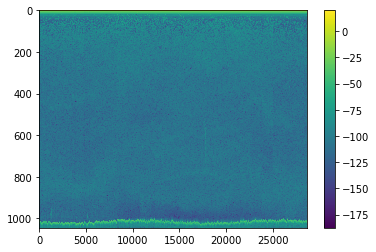

In [414]:
plt.imshow(power_data_dict[38000.0],aspect='auto')
plt.colorbar()
plt.show()

In [415]:
plt.imshow(power_data_dict[120000.0],aspect='auto')
plt.colorbar()
plt.show()

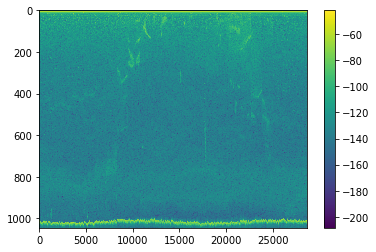

In [416]:
plt.imshow(power_data_dict[200000.0],aspect='auto')
plt.colorbar()
plt.show()